In [5]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
import csv
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

In [6]:
df = pd.read_csv('dataset.tsv', sep='\t', quoting=csv.QUOTE_NONE, dtype=str, encoding = 'utf-8',
                 header=None, names=["instance", "text", "id", "sentiment", "is_sarcastic"])

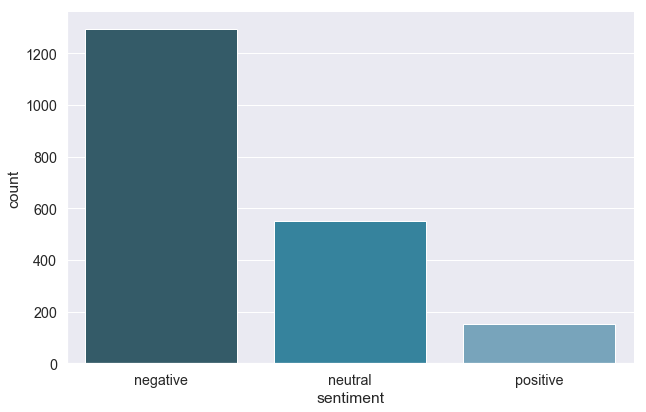

In [7]:
target_dist = sns.factorplot(x="sentiment", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [8]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [9]:
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
# Add airline_sentiment to df_eda
df_eda['sentiment'] = df.sentiment

In [10]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
            count       mean       std   min   25%   50%   75%   max
sentiment                                                           
negative   1294.0  20.506182  3.492723  6.0   18.0  21.0  23.0  30.0
neutral    553.0   19.245931  3.423214  6.0   17.0  20.0  22.0  30.0
positive   153.0   19.542484  3.316599  11.0  17.0  20.0  22.0  26.0


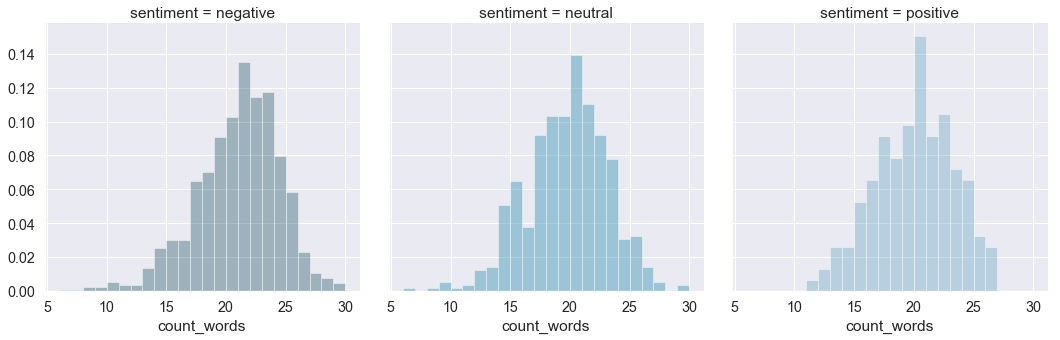

In [11]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
negative   1294.0  0.434312  0.764606  0.0  0.0  0.0  1.0  5.0
neutral    553.0   0.665461  0.839589  0.0  0.0  0.0  1.0  4.0
positive   153.0   0.496732  0.761959  0.0  0.0  0.0  1.0  3.0


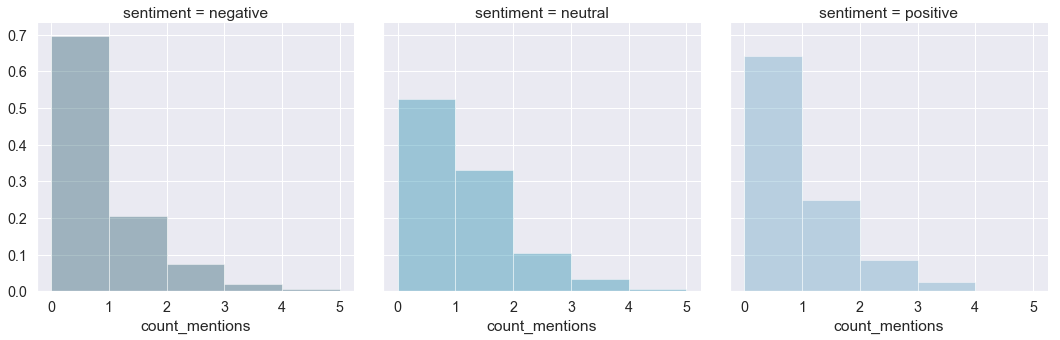

In [12]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   1294.0  2.368624  1.609419  1.0  1.0  2.0  3.0  11.0
neutral    553.0   1.996383  1.174913  1.0  1.0  2.0  2.0  9.0 
positive   153.0   2.274510  1.382386  1.0  1.0  2.0  3.0  7.0 


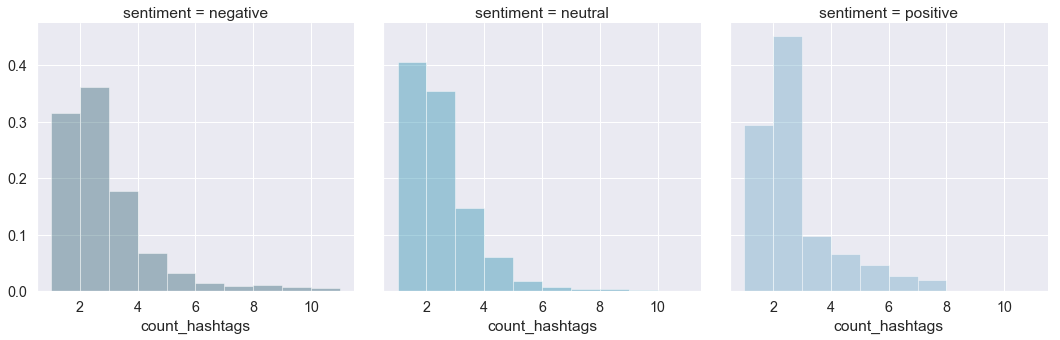

In [13]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   1294.0  1.060278  2.290452  0.0  0.0  0.0  1.0  20.0
neutral    553.0   0.558770  1.023581  0.0  0.0  0.0  1.0  9.0 
positive   153.0   0.686275  1.243248  0.0  0.0  0.0  1.0  7.0 


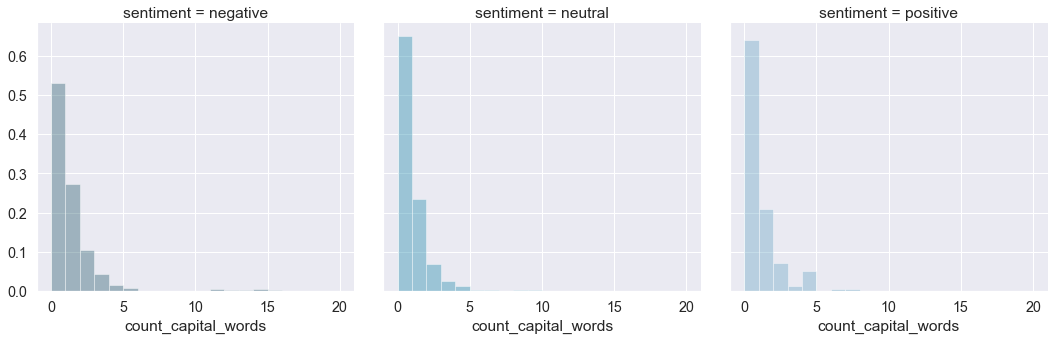

In [14]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
negative   1294.0  0.455178  0.915156  0.0  0.0  0.0  1.0  15.0
neutral    553.0   0.186257  0.531295  0.0  0.0  0.0  0.0  4.0 
positive   153.0   0.352941  1.028992  0.0  0.0  0.0  0.0  7.0 


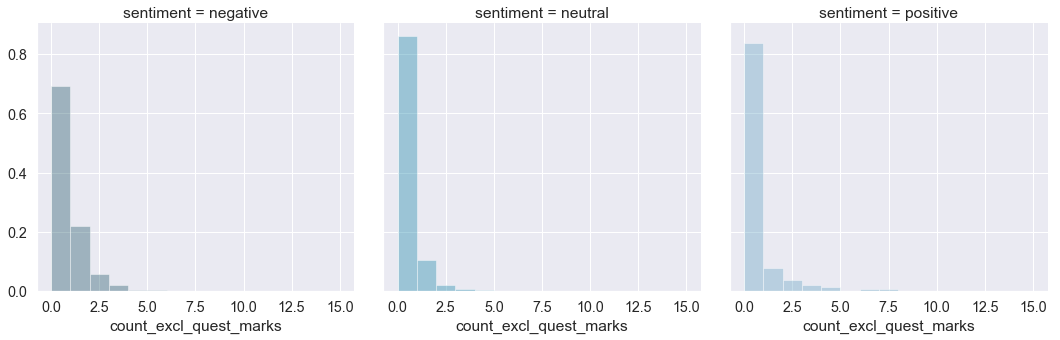

In [15]:
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
negative   1294.0  0.548686  0.548099  0.0  0.0  1.0  1.0  2.0
neutral    553.0   0.602170  0.581224  0.0  0.0  1.0  1.0  2.0
positive   153.0   0.607843  0.540897  0.0  0.0  1.0  1.0  2.0


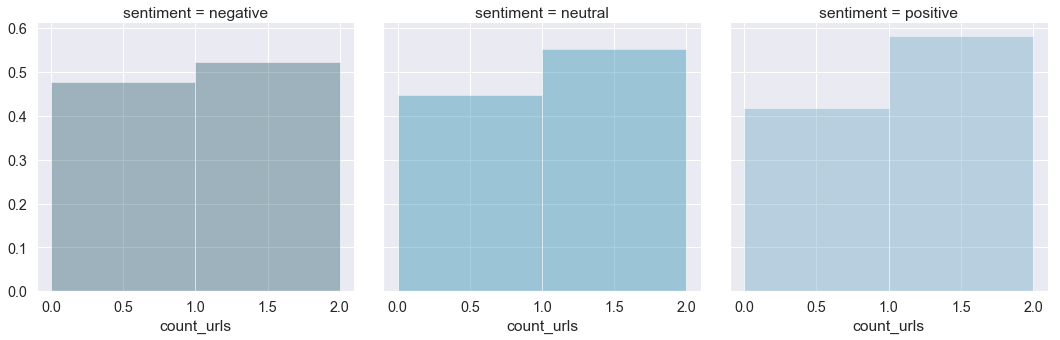

In [16]:
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
negative   1294.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0
neutral    553.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
positive   153.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0


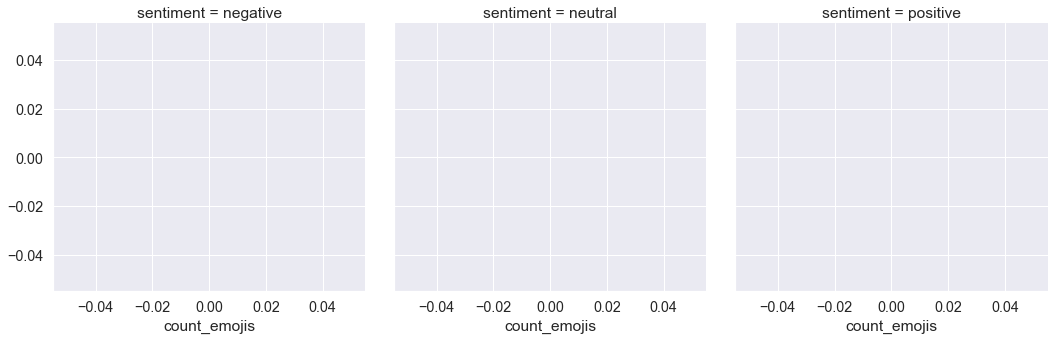

In [17]:
show_dist(df_eda, 'count_emojis')